# Dogs vs Cats - Classifying images as either Dogs or Cats

This project is based on a Kaggle Contest, the dataset used in this project is provided by kaggle and you can access it [here](https://www.kaggle.com/c/dogs-vs-cats/overview).

This is my project 5 of #100MLProjects.

I'm going to use Convolutional Neural Networks for this project, as CNN's perform incredibly well on image data.



In [4]:
# Initializing kaggle in google colab
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir .kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘.kaggle’: File exists


In [5]:
# Copying the data from kaggle to google colab
!kaggle competitions download -c dogs-vs-cats

 97% 529M/543M [00:04<00:00, 159MB/s]
100% 543M/543M [00:04<00:00, 119MB/s]
 97% 264M/271M [00:02<00:00, 128MB/s]
100% 271M/271M [00:02<00:00, 107MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 27.7MB/s]


In [6]:
!unzip dogs-vs-cats.zip

unzip:  cannot find or open dogs-vs-cats.zip, dogs-vs-cats.zip.zip or dogs-vs-cats.zip.ZIP.


In [7]:
!mkdir train
!unzip train.zip -d train
!mkdir test
!unzip test1.zip -d test

Streaming output truncated to the last 5000 lines.
  inflating: test/test1/55.jpg       
  inflating: test/test1/550.jpg      
  inflating: test/test1/5500.jpg     
  inflating: test/test1/5501.jpg     
  inflating: test/test1/5502.jpg     
  inflating: test/test1/5503.jpg     
  inflating: test/test1/5504.jpg     
  inflating: test/test1/5505.jpg     
  inflating: test/test1/5506.jpg     
  inflating: test/test1/5507.jpg     
  inflating: test/test1/5508.jpg     
  inflating: test/test1/5509.jpg     
  inflating: test/test1/551.jpg      
  inflating: test/test1/5510.jpg     
  inflating: test/test1/5511.jpg     
  inflating: test/test1/5512.jpg     
  inflating: test/test1/5513.jpg     
  inflating: test/test1/5514.jpg     
  inflating: test/test1/5515.jpg     
  inflating: test/test1/5516.jpg     
  inflating: test/test1/5517.jpg     
  inflating: test/test1/5518.jpg     
  inflating: test/test1/5519.jpg     
  inflating: test/test1/552.jpg      
  inflating: test/test1/5520.jpg     

In [8]:
# removing the zip file and cleaning up
!rm -r dogs-vs-cats.zip 
!rm -r train.zip 
!rm -r test1.zip 

rm: cannot remove 'dogs-vs-cats.zip': No such file or directory


In [9]:
import pandas as pd
import numpy as np
from keras import models, layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [10]:
import os
import shutil

About the data
- There are 25000 images of dogs and cats in total, with equal representation in the train dataset.
- 12500 images are available in the test dataset.
- I'm splitting the train dataset into train and validation dataset, with 20000 images and 5000 images respectively

In [11]:
# Create directories to store dog and cat images
train_dir = 'train'
test_dir = 'test'
train_dog_dir = os.path.join(train_dir, 'dog')
os.mkdir(train_dog_dir)

train_cat_dir = os.path.join(train_dir, 'cat')
os.mkdir(train_cat_dir)

val_dir = 'validation'
os.mkdir(val_dir)

val_dog_dir = os.path.join(val_dir, 'dog')
os.mkdir(val_dog_dir)

val_cat_dir = os.path.join(val_dir, 'cat')
os.mkdir(val_cat_dir)

src_path = os.path.join(train_dir, 'train')

# copy dog images into a folder named dog
fnames = ['dog.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
  src = os.path.join(src_path, fname)
  dst = os.path.join(train_dog_dir, fname)
  shutil.move(src, dst)

# copy first 10000 images into a directory named cat
fnames = ['cat.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
  src = os.path.join(src_path, fname)
  dst = os.path.join(train_cat_dir, fname)
  shutil.move(src, dst)

# copy remaining 2500 dog images into validation directory
fnames = ['dog.{}.jpg'.format(i) for i in range(10000, 12500)]
for fname in fnames:
  src = os.path.join(src_path, fname)
  dst = os.path.join(val_dog_dir, fname)
  shutil.move(src, dst)

# copy next 2500 images into validation directory
fnames = ['cat.{}.jpg'.format(i) for i in range(10000, 12500)]
for fname in fnames:
  src = os.path.join(src_path, fname)
  dst = os.path.join(val_cat_dir, fname)
  shutil.move(src, dst)

os.rmdir(src_path)

In [12]:
src_dir = 'test/test1'
dest_dir = 'test'

# Test Set
fnames = ['{}.jpg'.format(i) for i in range(1, 12501)]
for fname in fnames:
  src = os.path.join(src_dir, fname)
  dst = os.path.join(dest_dir, fname)
  shutil.move(src, dst)
os.rmdir(src_dir)
test_dir = dest_dir

In [13]:
print('Training Data dog images count: {}'.format(len(os.listdir(train_dog_dir))))
print('Training Data cat images count: {}'.format(len(os.listdir(train_cat_dir))))
print('Validation Data dog imgs count: {}'.format(len(os.listdir(val_dog_dir))))
print('Validation data cat imgs count: {}'.format(len(os.listdir(val_cat_dir))))
print('Test Data count: {}'.format(len(os.listdir(test_dir))))

Training Data dog images count: 10000
Training Data cat images count: 10000
Validation Data dog imgs count: 2500
Validation data cat imgs count: 2500
Test Data count: 12500


### Building a Convolutional Neural Network

I'm building a Sequential model with the following architecture

1. 2D Convolutional layer with 32 nodes, and 3x3 window
2. MaxPool2D layer with 2x2 window. This aggressively downsizes the image into half its size.
3. 2D Convolutional layer with 64 nodes, and 3x3 window
4. MaxPool2D layer with 2x2 window. 
5. 2D Convolutional layer with 128 nodes, and 3x3 window
6. MaxPool2D layer with 2x2 window. 
7. 2D Convolutional layer with 128 nodes, and 3x3 window
8. MaxPool2D layer with 2x2 window. 
9. Layer to flatten the 3D tensor into a vector that can be fed to a dense layer
10. first dense layer with 512 hidden units
11. second dense layer with 1 hidden unit and a sigmoid activation to output the probability of the image being a dog.

In [14]:
def build_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizers.RMSprop(learning_rate=1e-4))
  return model

In [15]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

This is the detailed architecture of the convolutional neural network created.

## Data Preprocessing

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode = 'binary'
)

valid_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode = 'binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [17]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=50
) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 110s 1s/step - loss: 0.6894 - accuracy: 0.5310 - val_loss: 0.6773 - val_accuracy: 0.5990
Epoch 2/30
100/100 [==============================] - 110s 1s/step - loss: 0.6671 - accuracy: 0.6165 - val_loss: 0.6973 - val_accuracy: 0.5330
Epoch 3/30
100/100 [==============================] - 112s 1s/step - loss: 0.6354 - accuracy: 0.6365 - val_loss: 0.6012 - val_accuracy: 0.6960
Epoch 4/30
100/100 [==============================] - 114s 1s/step - loss: 0.6003 - accuracy: 0.6765 - val_loss: 0.6434 - val_accuracy: 0.6260
Epoch 5/30
100/100 [==============================] - 110s 1s/step - loss: 0.5861 - accuracy: 0.6830 - val_loss: 0.5665 - val_accuracy: 0.7020
Epoch 6/30
100/100 [==============================] - 112s 1s/step - loss: 0.5594 - accuracy: 0.7120 - val_loss: 0.5473 - val_accuracy: 0.7190
Epoch 7/30
100/100 [==============================] - 114s 1s/step

In [19]:
model.save('cats_vs_dogs_1.h5')

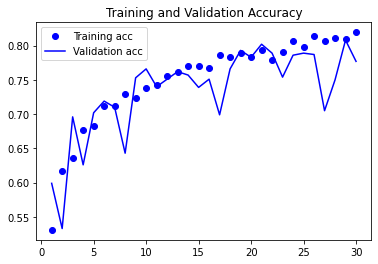

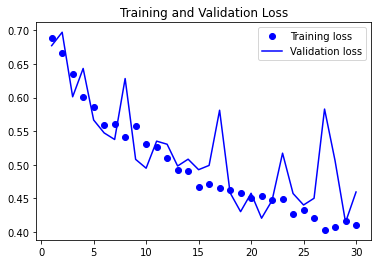

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()